이름: 김동영

학번: 20175111

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# np.random.seed(seed=0)

# 1. MNIST Dataset 불러오기

In [2]:
infile = open('mnist_49_random.pkl','rb')
mnist_data = pickle.load(infile)
infile.close()

In [3]:
mnist_data.keys()

dict_keys(['Xtrain', 'ytrain', 'Xtest', 'ytest'])

In [4]:
Xtrain = mnist_data['Xtrain']
ytrain = mnist_data['ytrain']
Xtest = mnist_data['Xtest']
ytest = mnist_data['ytest']

In [5]:
Xtrain[:][1].shape

(400,)

In [6]:
Xtrain.shape #800은 샘플의 갯수,  400은 20*20의 샘플의 크기

(800, 400)

In [7]:
ytrain.shape #800은 샘플의 갯수, 1은 각각의 Lable의 갯수

(800, 1)

In [8]:
ytest.shape

(200, 1)

label is [4]


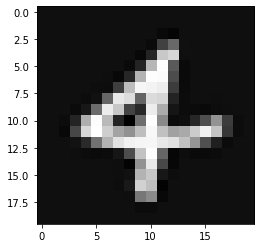

In [9]:
# Check samples
index = 3
image = Xtrain[index]
label = ytrain[index]

image_2D = image.reshape(20,20)
fig, ax = plt.subplots()
ax.imshow(image_2D, cmap='gray')
print('label is {}'.format(label))

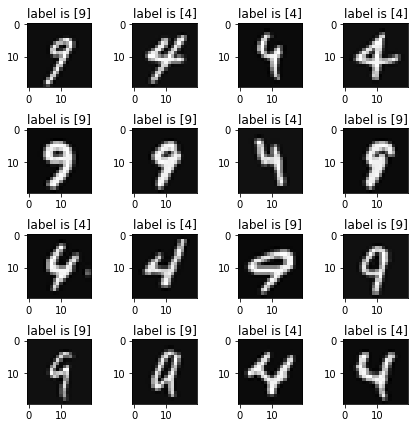

In [10]:
# Check samples
index = np.arange(16)
index = index.reshape(4,4)
image = Xtrain[index]
label = ytrain[index]

fig, axarr = plt.subplots(index.shape[0],index.shape[1], figsize=(6,6))
fig.tight_layout(pad=1.0)  
for i in np.arange(index.shape[0]):
    for j in np.arange(index.shape[1]):
        axarr[i,j].imshow(Xtrain[index[i,j], :].reshape(20,20), cmap='gray')
        axarr[i,j].set_title('label is {}'.format(ytrain[index[i,j]]))


## 2. Model

아래 실습에서는 logistic regression 무델 구현 및 샘플 연산을 수행하도록 하겠습니다.

### Problem 1 
Sigmoid 함수 
\begin{align*}
g(x) = \frac{1}{1+e^{-x}}
\end{align*}
를 연산하는 sigmoid 함수를 구현하세요.

- 함수명 `sigmoid()`
- 함수 입력: `x` np.array, 입력이 (n, m) array 이면 출력도 원소별로 sigmoid 적용하여 (n, m) array 출력하도록 구성
- 유용할 수 있는 함수: `np.exp()` 사용

In [11]:
# 답 작성:
def sigmoid(x):
    return 1 / (1+(np.exp(-x)))

잘 작성되었는지 확인

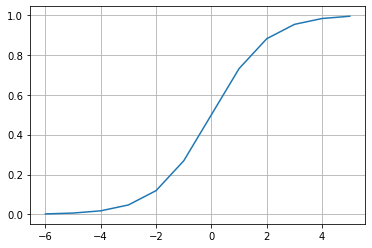

In [12]:
x_range = np.arange(-6, 6)

plt.plot(x_range, sigmoid(x_range))
plt.grid()

#### (보충) Python slicing의 기본 속성

우선 python에서 기본적으로 slicing 할때 생기는 속성에대해서 알아보죠.
다음 예제를 보겠습니다.

In [13]:
A = np.random.randint(0, 10, size=(3, 4))
A

array([[0, 6, 5, 4],
       [7, 5, 5, 1],
       [3, 0, 7, 2]])

첫 번째 row vector를 가져와서 a1row에 저정해보도록 하죠

In [14]:
a1row = A[0,:]
a1row

array([0, 6, 5, 4])

`a1row`의 `dim=1` 인것을 알수 있죠.

다음은 `a1col`에 `A`의 첫번째 column 을 vector로 저장해보죠

In [15]:
a1col = A[:,0]
a1col

array([0, 7, 3])

역시 `a1col`도 `dim=1` 입니다. 마지막으로 
`a12col`에 `A`행렬의 첫번째와 두번째 column vector를 저장해보죠.

In [16]:
a12col = A[:, 0:2]
a12col

array([[0, 6],
       [7, 5],
       [3, 0]])

이번에는 `a12col`은 `dim=2`인 ndarray로 가져왔습니다. 무슨 일관성이 이렇죠??
이유는 다음과 같습니다. numpy (또는 대부분의 python package)에서는 차원의 크기가 `1`인 부분은 모두 `squeeze` 즉 생략하여 돌려주는 기본적인 속성이 있습니다. 즉,  `A[0, :]`과 같이 받는 경우, 우리가 기대하는 값이 `(1, 4)`라면, `1`은 생략하고 돌려 줍니다. 즉 `A[0, :].shape`는 `(4,)`기 되는 것이죠.

In [17]:
test = np.random.randn(1,3)
test.shape

(1, 3)

In [18]:
test_squeezed = np.random.randn(1,1, 1, 1,3).squeeze()
test_squeezed.shape

(3,)

초기에 공부할때 코드에서 에러가 나지 않기 위해서 좋은 습관 중 한가지는 
<span style="color:red"> ndarray를 가능하면 dim=2로 연산하기</span> 입니다. 
shape를 봤을때, `(3, )`과 같이 1차원이면 모두 `(1,3)` 또는 `(3,1)`로 `reshape`.

물론 익숙해진후에는 필요에 맞게 자유롭게 사용하시고, 어떤 경우에는 1차원으로 입력해야하는 library 함수도 존재하니, 
적응은 필수입니다.

잠시 보충이었고, 모델 구현을 이어가도록 하겠습니다.


### Calculating linear operations
Vector 연산을 통한 선형 변환

\begin{align}
z &= \theta_1 x_1+\ldots+\theta_n x_n + \theta_0 \\
h_\theta(x) &= g(z)
\end{align}

\begin{align*}
\theta = \begin{bmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n 
\end{bmatrix}
\end{align*}
을 구하도록 하겠습니다. 지금까지 방법과는 다르게, 모두 행렬연산으로 수행하도록 배우겠습니다.

일단, parameter `theta`를 생성하도록 하죠.

`Xtrain`을 잘 이해하고 있는지 몇가지 확인해보죠:
- $x^{(i)}\in\mathbb{R}^n$는 $i$ 번째 샘플, 즉, $i$ 번째 image `Xtrain[0,:].reshape(-1,1)` 이 됩니다.
- 즉, $(x^{(i)})^T$는 $i$ 번째 샘플을 전치한, `Xtrain[0,:].reshape(1,-1)` 이 됩니다. 
- $x^{(i)}_1$은 $i$ 번째 샘플의 첫번째 픽셀값, 즉, $i$ 번째 image의 `Xtrain[0,1]` 이죠? 


## Problem 2-1

- 아래 $\theta\in \mathbb{R}^{n+1}$ vector를 `theta`라는 변수로 초기값 Gaussian 분포에 맞춰서 생성합니다. 
- 왜 $\theta$의 차원은 $n+1$인지 설명하고, 아래 코드에서 왜 `Xtrain.shape[1]+1`로 `theta`의 크기를 생성했는지 설명하세요. 

In [19]:
theta = np.random.randn(Xtrain.shape[1]+1, 1)

답 작성) x의 샘플의 갯수는 n이고, bias까지 고려하여 1을 더하였다. (중요!!!) / 코드를 보면, Xtrain.shape[1]은 x의 샘플의 갯수, 역시 bias를 고려하여 1을 더하였다. / 이는 One-Trick을 사용할 것을 고려한 조치이다. / 그리고, 8번 문제에서 gradient와 theta를 통해 SGD를 업데이트 해야 하는데, gradient의 shape가 (401, 1)이므로 추후 계산을 위해서 shape를 조정한 이유 또한 존재한다. gradient()는 Xtrain_tilde (1이 추가된 Xtrain 행렬) 인자로 전달 되기 때문에, 결과의 shape가 (401, 1)로 나온다.

위에서 정의한 $z$를 $x^{(1)}$에 대해서 연산해보도록 하죠. 즉, 
\begin{align}
z &= \theta_1 x^{(1)}_1+\ldots+\theta_n x^{(1)}_n + \theta_0 
\end{align}

In [20]:
z = np.sum(theta[1:, 0]*Xtrain[0,:]) + theta[0, 0]
z

-2.2063740948614714

수업에서 배운 `one-trick`을 이용해보죠.
\begin{align*}
z &= \theta_0\cdot 1 + \theta_1 x^{(1)}_1+\ldots+\theta_n x^{(1)}_n  \\
 &= \theta_0 \tilde x^{(1)}_0 + \theta_1 \tilde x^{(1)}_1+\ldots+\theta_n \tilde x^{(1)}_n  \\
 &= \theta^T \tilde x^{(1)}
\end{align*}
where
\begin{align*}
\tilde x^{(1)} = \begin{bmatrix}
1\\
x^{(1)}
\end{bmatrix}
\end{align*}


In [21]:
x1 = Xtrain[0, :].reshape(-1,1)

In [22]:
x1_tilde = np.vstack([1, x1])

In [23]:
x1_tilde.shape

(401, 1)

In [24]:
x1_tilde[0]

array([1.])

In [25]:
z_with_tilde = np.matmul(theta.T, x1_tilde)
z_with_tilde

array([[-2.20637409]])

다음 단계로 아래와 같이 정의해보죠.
\begin{align*}
\tilde X = \begin{bmatrix}
1 & (x^{(1)})^T\\
1 & (x^{(2)})^T\\
\vdots\\
1 & (x^{(m)})^T
\end{bmatrix}
\end{align*}

## Problem 2-2
`Xtrain_tilde`라는 변수에 위 행렬을 만드세요.
- 사용할 함수: `np.hstack()`, `np.ones()`


In [26]:
# 답작성

Xtrain_tilde = np.hstack((np.ones(Xtrain.shape[0]).reshape(-1,1), Xtrain))
print(Xtrain_tilde)
print(Xtrain_tilde.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(800, 401)


다음 목표는 아래와 같은 연산을 수행하는 것입니다.

\begin{align*}
\tilde X = \begin{bmatrix}
(\tilde x^{(1)})^T\\
(\tilde x^{(2)})^T\\
\vdots\\
(\tilde x^{(m)})^T
\end{bmatrix}
\Rightarrow
\text{어떤 연산}
\Rightarrow
\begin{bmatrix}
(\tilde x^{(1)})^T\theta\\
(\tilde x^{(2)})^T\theta\\
\vdots\\
(\tilde x^{(m)})^T\theta
\end{bmatrix}
\end{align*}

정말 `어떤 연산`을 찾으라는 문제를 내고 싶은 생각이 굴뚝 같지만, 참고 답을 말씀드리면:
\begin{align*}
\tilde X \theta = \begin{bmatrix}
(\tilde x^{(1)})^T\theta\\
(\tilde x^{(2)})^T\theta\\
\vdots\\
(\tilde x^{(m)})^T\theta
\end{bmatrix}
\end{align*}

행렬곱의 정의 그 자체입니다. 설명도 필요없어요. 시험문제입니다. 뿐만 아니라 이미 문제로 수없이 냈던 문제입니다. 제발 이것만은 알고 있어주세요.

## Exercise 1

`ytrain`의 label 값을 다음과 같이 변환

- label `4`를 label `1`로 변경
- label `9`를 label `0`로 변경
- `y`에 저장

In [27]:
# 답 작성
y = np.zeros_like(ytrain)
y[ytrain==4]=1
y[ytrain==9]=0

In [28]:
y[:10]

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1]], dtype=uint8)

In [29]:
ytrain[:10]

array([[9],
       [4],
       [4],
       [4],
       [9],
       [9],
       [4],
       [9],
       [4],
       [4]], dtype=uint8)

# 3. 모델을 행렬곱으로 구현

마지막은 지금까지 배운 모든 것을 하나로 이어보는 것입니다.
\begin{align*}
h_\theta(x^{(i)}), \quad i=1,\ldots, m
\end{align*}
에 대한 결과들을 `H`라는 변수에 아래와 같이 구하세요:

\begin{align*}
H = \begin{bmatrix}
h_\theta(x^{(1)}) \\
h_\theta(x^{(2)}) \\
\vdots\\
h_\theta(x^{(m)}) 
\end{bmatrix}
\end{align*}

참고로

\begin{align*}
\begin{bmatrix}
h_\theta(x^{(1)}) \\
h_\theta(x^{(2)}) \\
\vdots\\
h_\theta(x^{(m)}) 
\end{bmatrix} = 
\begin{bmatrix}
\sigma((\tilde x^{(1)})^T \theta) \\
\sigma((\tilde x^{(2)})^T \theta) \\
\vdots\\
\sigma((\tilde x^{(m)})^T \theta)
\end{bmatrix}
\end{align*}
인 것을 기억하죠. 문제의 의도를 파악하세요. 위에서 구한 것들을 활용하여 행렬곱과 `sigma`함수로 한줄입니다.

## Problem 3

`model` 함수를 다음과 같이 구현하세요

- `input`: dataset 행렬 (one-trick 적용한) `X`와 `theta` 
- `output`: $H$ 행렬
- 행렬 곱을 통해서 연산!

In [30]:
#답 작성
#One-Trick을 적용한 X_train값과 theta를 곱한 값을 Sigmoid함수에 입력
def model(X, theta):
    return sigmoid(np.matmul(X,theta))

In [31]:
H = model(Xtrain_tilde, theta)
H.shape

(800, 1)

## Problem 4

다음 출력 값을 $h_\theta(x^{(i)})$ 로 설명하세요 (즉, $i$=?)

In [32]:
H[20,0]

0.03898765141613621

답 작성) 19. 이 값은 모델을 적용한 결과의 행렬(H)에 저장되어 있는 19번째 값이다. (인덱스는 0에서 시작하기 때문)

# 4. Decision boundary and accuracy

다음은 모델 output 확률 정보로부터 label을 예측하는 함수를 만들도록 하겠습니다.

모델의 출력 값은 $p(y=1|x;\theta)$ 즉, image가 `4`일 확률 값입니다.


## Problem 5
- 다음 `decision(H, p, y)` 함수를 작성하세요. 
- decision boundary를 `p`로 정하고
- `H`의 원소 값이 `p`보다 크거나 같으면 `1`
- `H`의 원소 값이 `p`보다 작으면 `0`이 되는 행렬 `pred`를 만들고
- `pred`와 `y`를 비교하여 정답률을 계산하여 `accuracy`에 저장하세요

- `output`은 `pred`와 `accuracy`를 출력하세요

In [33]:
def decision(H, p, y):
    # 답작성
    '''
    pred = np.zeros(Xtrain.shape[0]).reshape(-1,1)
    accuracy = 0
    for i in range(0,Xtrain.shape[0]):
        if (H[i,:]>=p):
            pred[i] = 1
            if(pred[i] == y[i]):
                accuracy += 1
        else:
            pred[i] = 0
    
    accuracy = (accuracy / Xtrain.shape[0]) * 100
    '''
    
    pred = np.zeros_like(y)
    pred[H>=p] = 1
    accuracy = np.sum(pred == y)/y.shape[0]
    return pred, accuracy

In [34]:
pred, acc = decision(H, 0.5, y)

In [35]:
acc

0.43875

# 5. Cost function

이론 수업에서 본 것과 같이 cost 함수는 
\begin{align*}
J(\theta) &= -\log L(\theta)\\
&= \frac{1}{m}\sum_{i=1}^m  -y^{(i)}\log h(x^{(i)})-(1-y^{(i)})\log(1-h(x^{(i)}))
\end{align*}
으로 주어집니다.

이를 vectorization을 통해서 연산하면
\begin{align*}
J(\theta) = \frac{1}{m}\left(-y^T\log(H) - (1-y)^T\log(1-H)\right)
\end{align*}
이유는 아래와 같기 때문이죠:
\begin{align*}
y^T\log(H) &= \begin{bmatrix}
y^{(1)} & y^{(2)} & \cdots & y^{(m)}
\end{bmatrix}
\begin{bmatrix}
\log(h_\theta(x^{(1)})) \\
\log(h_\theta(x^{(2)})) \\
\vdots \\
\log(h_\theta(x^{(m)})) 
\end{bmatrix}\\
& = \sum_{i=1}^m  y^{(i)}\log h(x^{(i)})
\end{align*}



## Problem 6

`cost` 함수를 다음과 같이 구현하세요

- `input`: model 출력 행렬 `H`와 label `y` 
- `output`: $H$ 행렬

\begin{align*}
J(\theta) = \frac{1}{m}\left(-y^T\log(H) - (1-y)^T\log(1-H)\right)
\end{align*}

In [36]:
# 답 작성
def cost(H, y):
    return -np.matmul(y.T,np.log(H))-np.matmul((1-y).T,np.log(1-H)) / Xtrain.shape[0]

In [37]:
cost(H, y)

array([[1797.4127381]])

# 5. Computing the gradient

\begin{align*}
\nabla_\theta J(\theta) = \frac{1}{m}X^T(H-y)
\end{align*}

## Problem 7

`grad` 함수를 다음과 같이 구현하세요

- `input`: model 출력 행렬 `H`, `X`(dataset, one-trick적용), 와 label `y` 
- `output`: Gradient 행렬

In [38]:
def grad(X, H, y):
    return np.matmul(X.T,(H-y)) /Xtrain.shape[0]

In [39]:
grad(Xtrain_tilde, H, y).shape

(401, 1)

위 `grad`함수의 `shape`가 왜 `(401,1)`인지 설명하세요

답 작성) Xtrain_tilde.T의 shape는 (401,800)이고, (H-y)의 shape은 (800,1)이다. 이 둘을 내적연산 하면 (401,1)이라는 결과가 나온다.

## Problem 8

위에서 구한 함수들을 이용하여 학습을 진행하고 결과를 `epoch` 별로 loss 값을 저장하세요

- 코드에 모든 줄에 주석을 최대한 상세하게 작성하세요. 주석이 없으면 0점 처리합니다.
- learning rate과 epoch를 조절하면서 최대 성능을 내도록 변경하세요

In [40]:
theta = np.random.randn(Xtrain.shape[1]+1, 1)
theta.shape
grad(Xtrain_tilde, H, y).shape

(401, 1)

In [41]:
num_epoch = 1000 # epoch 총 수
lr = 0.01 # learning rate

# epoch 별 loss 저장하기 위한 array
loss = np.zeros(num_epoch)
accuracy = np.zeros(num_epoch)

# theta 초기화
#np.random.seed(seed=0)
theta = np.random.randn(Xtrain.shape[1]+1, 1)

skip = 100
for e in range(num_epoch):
    
    # 모델 적용
    H = model(Xtrain_tilde, theta)
    # 현재 epoch loss 계산 및 저장
    loss[e] = cost(H,y)
    # 현재 epoch accuracy 계산 및 저장
    pred, accuracy[e] = decision(H, 0.5, y)
    # Gradient 계산
    gradient = grad(Xtrain_tilde, H, y)
    # SGD Update
    theta = theta - lr * gradient
    
    if e%skip == 0:
        print(f'--- starting epoch {e} ----')
        print('accuracy = ', accuracy[e])
        print('loss = ', loss[e])
    
    

--- starting epoch 0 ----
accuracy =  0.5
loss =  1322.465090197438
--- starting epoch 100 ----
accuracy =  0.52625
loss =  727.1761512466782
--- starting epoch 200 ----
accuracy =  0.57875
loss =  527.5354926535201
--- starting epoch 300 ----
accuracy =  0.62
loss =  424.7104058286599
--- starting epoch 400 ----
accuracy =  0.675
loss =  359.66135510282976
--- starting epoch 500 ----
accuracy =  0.71125
loss =  315.2635826365229
--- starting epoch 600 ----
accuracy =  0.7425
loss =  283.1070310044262
--- starting epoch 700 ----
accuracy =  0.76
loss =  258.56620895895
--- starting epoch 800 ----
accuracy =  0.78625
loss =  239.02537876031676
--- starting epoch 900 ----
accuracy =  0.7975
loss =  222.93753757685204


Text(0, 0.5, 'Accuracy')

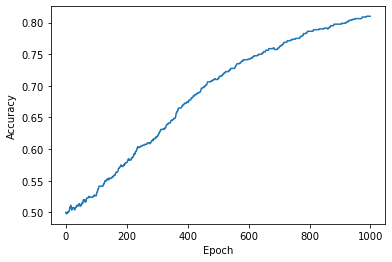

In [42]:
plt.plot(accuracy, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

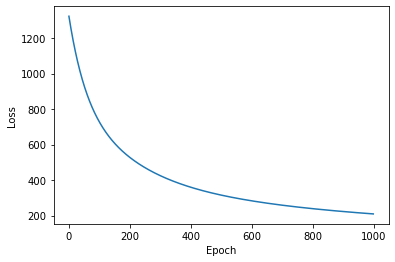

In [43]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Problem 9

Testset에 학습한 모델 적용하여 성능 평가하기

- Testset에 대한 loss와 accuracy를 각각 계산하여 출력하세요
- one-trick과 label 변환은 제가 해드리겠습니다


In [44]:
# Data 불러오기
Xtest = mnist_data['Xtest']
ytest = mnist_data['ytest']

In [45]:
# One-trick
Xtest = np.hstack([np.ones((Xtest.shape[0], 1)), Xtest])

In [46]:
# Label 변환
ytest[ytest==4] = 1
ytest[ytest==9] = 0

In [47]:
# 답 작성
def test_cost(H, y):
    return -np.matmul(y.T,np.log(H))-np.matmul((1-y).T,np.log(1-H)) / Xtest.shape[0]

In [48]:
# 답 작성
test_loss = test_cost(model(Xtest,theta),ytest)
test_pred, test_accuracy = decision(model(Xtest,theta), 0.5, ytest)

In [49]:
# Testset 성능
print('test_loss=', test_loss)
print('test_accuracy=', test_accuracy)

test_loss= [[76.56781241]]
test_accuracy= 0.78
